<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day8_am_morning/D8_M_Tabular_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pyvirtualdisplay

In [ ]:
import gym
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class DenseReward(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.done = done
        return observation, self.reward(reward), done, info

    def reward(self, reward):
        if reward == 0:
          if self.done:
            return -10
          return -1
        else:
          return 100

In [ ]:
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)
env = DenseReward(env)

## SARSA

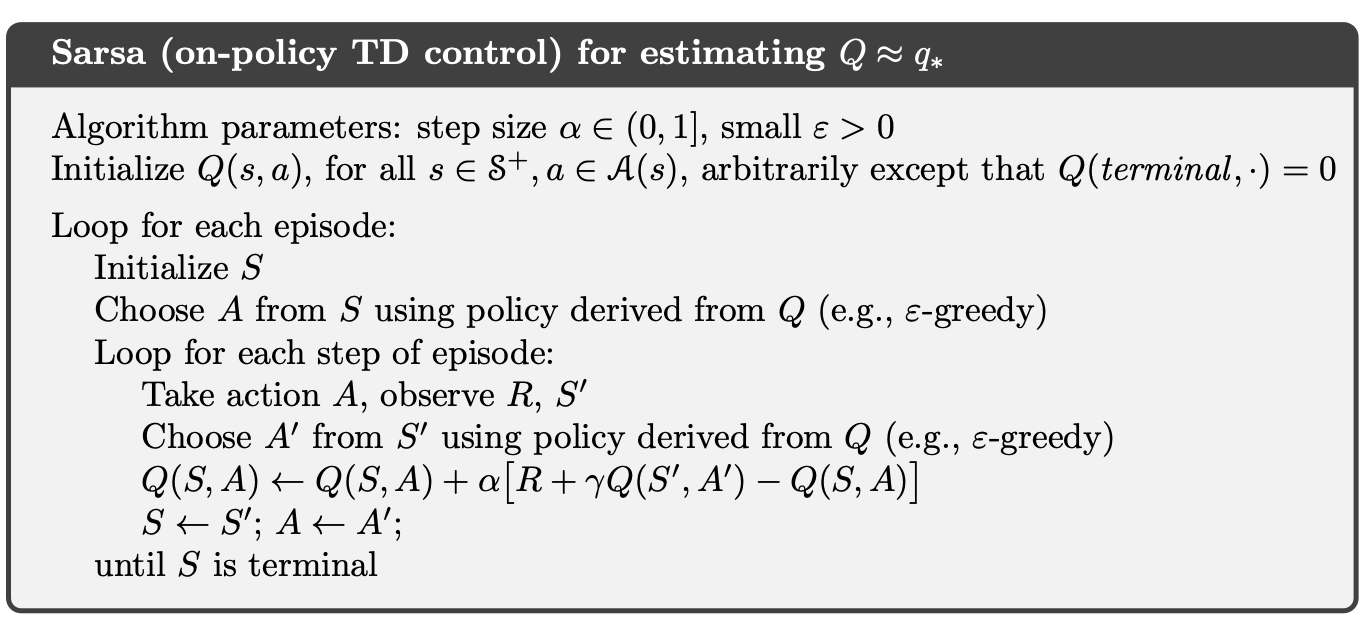

In [ ]:
def epsilon_greedy(env, state, Q, epsilon):
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state,:])

In [ ]:
def SARSA(env, num_episodes, lr, epsilon, gamma):
    q = np.zeros((env.observation_space.n, env.action_space.n))
    undiscounted_rewards = []
    for i in trange(num_episodes):
        state = env.reset()
        action = epsilon_greedy(env, state, q, epsilon)
        undis_rewards = 0.0
        while True:
            next_state, reward, done, info = env.step(action)
            next_action = epsilon_greedy(env, next_state, q, epsilon)
            undis_rewards += reward
            if done:
                q[state, action] = q[state,action] + lr *(reward + gamma * 0 - q[state,action])
                break
            else:
                q[state, action] += lr * (reward + gamma * q[next_state, next_action] - q[state, action])
                state = next_state
                action = next_action
        undiscounted_rewards.append(undis_rewards)
    return q, undiscounted_rewards

In [ ]:
num_episodes = 1000

In [ ]:
sarsa_q, sarsa_undiscounted_rewards = SARSA(env, num_episodes, 0.1, 0.1, 0.9)

In [ ]:
plt.plot(sarsa_undiscounted_rewards)
plt.title("SARSA algorithm - undiscounted return")
plt.show()

In [ ]:
env2 = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)
env2 = DenseReward(env2)

In [ ]:
num_episodes=1000
sarsa_q2, sarsa_undiscounted_rewards2 = SARSA(env2, num_episodes, 0.1, 0.1, 0.9)

In [ ]:
plt.plot(sarsa_undiscounted_rewards2)
plt.title("SARSA algorithm - undiscounted return - 8x8 is_slippery:True")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [ ]:
num_runs = 5
total_returns = []
for _ in range(num_runs):
    obs = env2.reset()
    done = False
    rewards = 0
    while not done:
      action = epsilon_greedy(env2, obs, sarsa_q2, 0.01)
      obs, reward, done, info = env2.step(action)
      rewards += reward
      ipythondisplay.clear_output(wait=True)
      plt.imshow(env2.render(mode="rgb_array"))
      plt.axis('off')
      plt.show()
      ipythondisplay.display(plt.gcf())
      if done:
          obs = env2.reset()
          total_returns.append(rewards)
plt.plot(total_returns)
plt.title(f"SARSA: Returns across {num_runs} runs")
plt.show()


## Q-learning

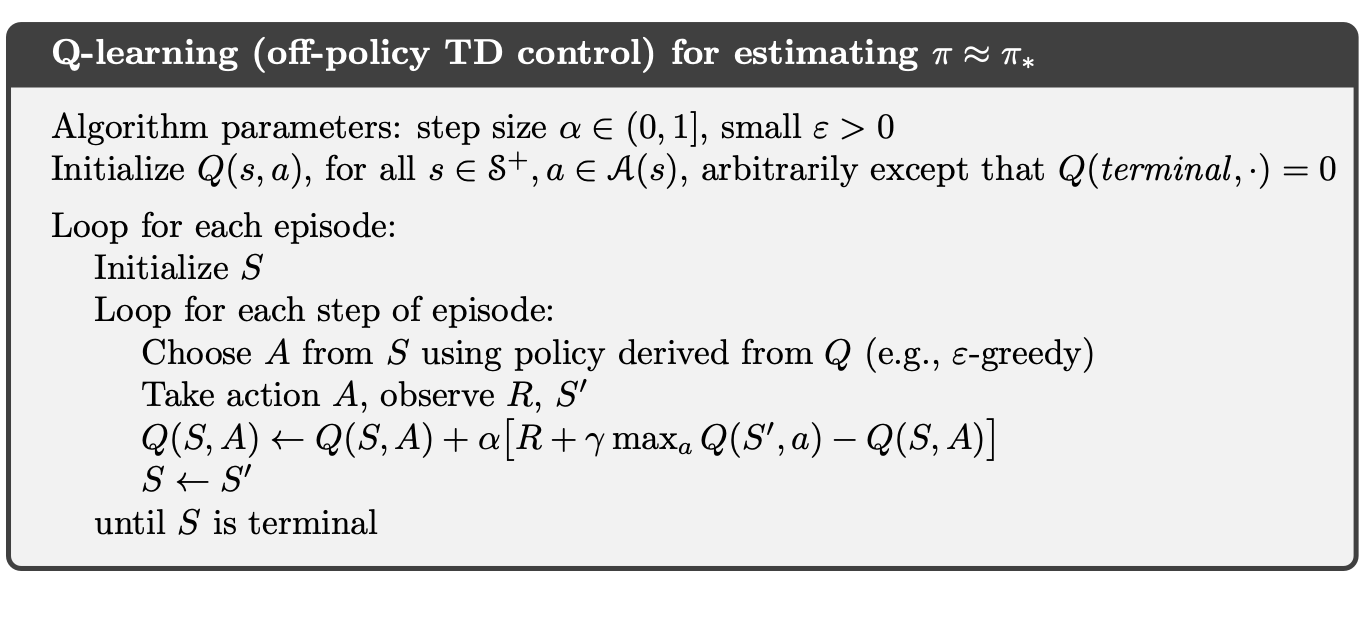

In [ ]:
def QLearning(env, num_episodes, lr, epsilon, gamma, epsilon_decay=0.999):
    q = np.zeros((env.observation_space.n, env.action_space.n))
    undiscounted_rewards = []
    # Epsilon decay parameters
    min_epsilon = 0.01
    for i in trange(num_episodes):
        state = env.reset()
        undis_rewards = 0.0
        done = False
        while not done:
            action = epsilon_greedy(env, state, q, epsilon)
            next_state, reward, done, info = env.step(action)
            undis_rewards += reward
            q[state, action] += lr * (reward + gamma * np.max(q[next_state, :]) - q[state, action])
            state = next_state
        undiscounted_rewards.append(undis_rewards)
        epsilon = max(min_epsilon, epsilon_decay * epsilon)
    return q, undiscounted_rewards

In [ ]:
num_episodes=1000
decayed_Q_qlearning, decayed_ql_undiscounter_return = QLearning(env, num_episodes, 0.1, 0.1, 0.99,epsilon_decay=0.999)
Q_qlearning, ql_undiscounter_return = QLearning(env, num_episodes, 0.1, 0.1, 0.99, epsilon_decay=1)

In [ ]:
plt.plot(ql_undiscounter_return, label="q-learning")
plt.plot(decayed_ql_undiscounter_return, label="decayed q-learning")
plt.title("QLearning algorithm - Rewards")
plt.legend()
plt.show()

In [ ]:
num_runs = 5
total_returns = []
for _ in range(num_runs):
    obs = env.reset()
    done = False
    rewards = 0
    while not done:
      action = epsilon_greedy(env, obs, Q_qlearning, 0.01)
      obs, reward, done, info = env.step(action)
      rewards += reward
      ipythondisplay.clear_output(wait=True)
      plt.imshow(env.render(mode="rgb_array"))
      plt.axis('off')
      plt.show()
      ipythondisplay.display(plt.gcf())
      if done:
          obs = env.reset()
          total_returns.append(rewards)
plt.plot(total_returns)
plt.title(f"Returns across {num_runs} runs")
plt.show()

In [ ]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [ ]:
plt.plot(moving_average(sarsa_undiscounted_rewards), label='sarsa')
plt.plot(moving_average(ql_undiscounter_return), label='qlearning')
plt.plot(moving_average(decayed_ql_undiscounter_return), label='decayed-qlearning')
plt.grid()
plt.title("4x4 FrozenLake")
plt.legend()
plt.show()

In [ ]:
num_episodes=1000
decayed_Q_qlearning2, decayed_ql_undiscounter_return2 = QLearning(env2, num_episodes, 0.1, 0.1, 0.99,epsilon_decay=0.999)
Q_qlearning2, ql_undiscounter_return2 = QLearning(env2, num_episodes, 0.1, 0.1, 0.99, epsilon_decay=1)

In [ ]:
plt.plot(moving_average(sarsa_undiscounted_rewards2), label='sarsa')
plt.plot(moving_average(ql_undiscounter_return2), label='qlearning')
plt.plot(moving_average(decayed_ql_undiscounter_return2), label='decayed-qlearning')
plt.grid()
plt.title("8x8 FrozenLake")
plt.legend()
plt.show()

### Exercise:

Implement Expected SARSA

Expected SARSA is an off-policy Temporal Difference control algorithm. It's quite similar to Q-learning and SARSA but instead of using a sample action to estimate the next state's value, it takes the expected value over all possible actions according to the current policy.

Here's a step-by-step breakdown of the Expected SARSA update:

1. Initialize $Q(s,a)$ arbitrarily, for all states s and actions a.
2. Loop for each episode:
   - Initialize the state, s.
   - Choose an action, a, from s using a policy derived from Q (e.g., epsilon-greedy).
   - Loop for each step of the episode until s is terminal:
     - Take action a, observe reward r and next state s'.
     - Choose a' from s' using a policy derived from Q (e.g., epsilon-greedy).
     
      Compute the expected value of the next state-action pair: $E[Q(s,a)] = \sum_{a'} \pi(a'|s') Q(s',a')$. Here, $\pi(a'|s')$ is the probability of taking action a' in state s' under the current policy.
     - Update the Q-value using the Expected SARSA update rule:
       $Q(s,a) = Q(s,a) + \alpha [r + \gamma E[Q(s',a')] - Q(s,a)]$.
     - s = s'.
     - a = a'.
     
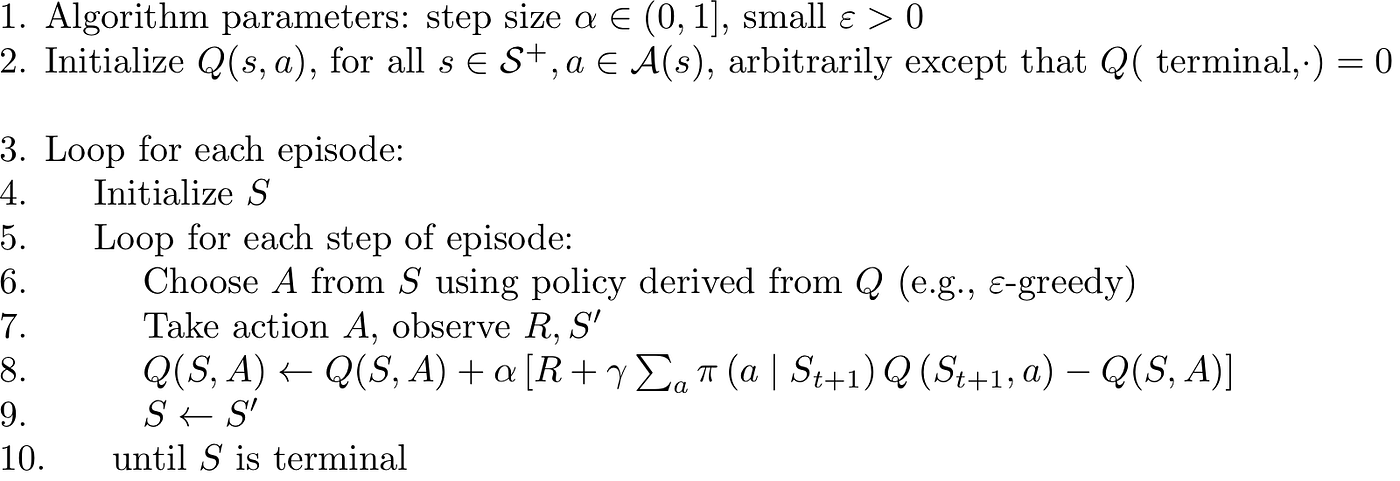

In [ ]:
def expectedSARSA(env, num_episodes, lr, epsilon, gamma):
    q = np.zeros((env.observation_space.n, env.action_space.n))
    undiscounted_rewards = []
    for i in trange(num_episodes):
        state = env.reset()
        action = epsilon_greedy(env, state, q, epsilon)
        undis_rewards = 0.0
        while True:
            next_state, reward, done, info = env.step(action)
            next_action = epsilon_greedy(env, next_state, q, epsilon)
            undis_rewards += reward
            if done:
                q[state, action] = q[state,action] + lr *(reward + gamma * 0 - q[state,action])
                break
            else:
                policy = np.ones(env.action_space.n) * epsilon / env.action_space.n
                best_action = np.argmax(q[next_state])
                policy[best_action] += (1.0 - epsilon)
                expected_term = sum(q[next_state] * policy)
                q[state, action] += lr * (reward + gamma * expected_term - q[state, action])
                state = next_state
                action = next_action
        undiscounted_rewards.append(undis_rewards)
    return q, undiscounted_rewards

In [ ]:
num_episodes=1000
expectedSARSA_q, expectedSARSA_undiscounter_return = expectedSARSA(env, num_episodes, 0.1, 0.1, 0.9)
expectedSARSA_q2, expectedSARSA_undiscounter_return2 = expectedSARSA(env2, num_episodes, 0.1, 0.1, 0.9)

In [ ]:
plt.plot(expectedSARSA_undiscounter_return)
plt.title("Expected SARSA algorithm - Rewards")
plt.show()

In [ ]:
num_runs = 5
total_returns = []
for _ in range(num_runs):
    obs = env.reset()
    done = False
    rewards = 0
    while not done:
      action = epsilon_greedy(env, obs, Q_qlearning, 0.01)
      obs, reward, done, info = env.step(action)
      rewards += reward
      ipythondisplay.clear_output(wait=True)
      plt.imshow(env.render(mode="rgb_array"))
      plt.axis('off')
      plt.show()
      ipythondisplay.display(plt.gcf())
      if done:
          obs = env.reset()
          total_returns.append(rewards)
plt.plot(total_returns)
plt.title(f"Returns across {num_runs} runs")
plt.show()

In [ ]:
plt.plot(moving_average(sarsa_undiscounted_rewards), label='sarsa')
plt.plot(moving_average(ql_undiscounter_return), label='qlearning')
plt.plot(moving_average(decayed_ql_undiscounter_return), label='decayed-qlearning')
plt.plot(moving_average(expectedSARSA_undiscounter_return), label='expected-sarsa')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(moving_average(sarsa_undiscounted_rewards2), label='sarsa')
plt.plot(moving_average(ql_undiscounter_return2), label='qlearning')
plt.plot(moving_average(decayed_ql_undiscounter_return2), label='decayed-qlearning')
plt.plot(moving_average(expectedSARSA_undiscounter_return2), label='expected-sarsa')
plt.grid()
plt.legend()
plt.show()